# Aplicação de Cluster no Dataset MAFAULDA

In [1]:
library(tidyverse)
library(dbscan)
library(umap)
set.seed(12)

-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'dbscan'


The following object is masked from 'package:stats':

    as.dendrogram




## Carrega os dados
Os dados são correspondentes aos harmônicos da série temporal do motor

In [2]:
dados <- read_csv('D:/share/motor_vibration_dataset.csv')

Rows: 1104 Columns: 801
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr   (1): file_name
dbl (800): tachometer_harmonic_1_frequency, tachometer_harmonic_1, tachomete...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Limpa os dados
Os dados são limpos e os rótulos são divididos em duas colunas.

In [3]:
dados <- dados %>% 
    mutate(file_name = str_replace_all(file_name, pattern = '\\./motorvibration/Data/', replacement = '')) %>%
    mutate(file_name = str_replace_all(file_name, pattern = '/[0-9\\.]*.csv$', replacement = '')) %>%
    separate(file_name, c("type", 'un'), sep='/') %>%
    mutate(type = factor(type))

Warning message:
"Expected 2 pieces. Missing pieces filled with `NA` in 49 rows [531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541,
542, 543, 544, 545, 546, 547, 548, 549, 550, ...]."


In [4]:
dados %>% group_by (type) %>% summarise(Total=n())

type,Total
<fct>,<int>
horizontal-misalignment,197
imbalance,333
normal,49
overhang-ball_fault,88
underhang-ball_fault,136
vertical-misalignment,301


## Redução de dimensão
Para evitar o excesso de outliers o algoritmo UMAP para redução de dimensões foi utilizado.

# Uniform Manifold Approximation and Projection (UMAP) - Descrição do ChatGTP

## Introdução

O **UMAP** é um algoritmo de redução de dimensionalidade amplamente utilizado em aprendizado de máquina e visualização de dados. Foi introduzido por *Leland McInnes* e *John Healy* em 2018 e é baseado em princípios de geometria diferencial e teoria dos grafos.

O objetivo principal do UMAP é projetar dados de alta dimensionalidade em um espaço de menor dimensão, preservando ao máximo as estruturas locais e globais do conjunto original.

---

## Fundamentos Matemáticos

O UMAP utiliza conceitos de:

1. **Geometria Diferencial**: Define uma métrica Riemanniana nos dados para modelar sua estrutura local.
2. **Teoria de Grafos**: Constrói um grafo baseado em vizinhos próximos para capturar relações locais.
3. **Topologia Algébrica**: Relaciona a estrutura de alta dimensão ao grafo resultante.

### Etapas do Algoritmo

1. **Construção do Grafo de Similaridade**:
   - Cada ponto no espaço original é considerado como um nó no grafo.
   - Define-se um conjunto de vizinhos próximos usando a métrica **k-nearest neighbors (k-NN)**.
   - Uma função de afinidade (ou probabilidade) é atribuída às arestas do grafo para medir a similaridade entre pontos.

2. **Redução de Dimensionalidade**:
   - O grafo de alta dimensão é aproximado em um espaço de menor dimensão.
   - A otimização é feita através da minimização de uma **função de perda** que compara a estrutura dos grafos nos dois espaços (original e reduzido).

---

## Principais Características

- **Preservação de Estruturas Locais**: UMAP prioriza manter vizinhanças próximas no espaço reduzido.
- **Flexibilidade**: Suporta dados de diferentes métricas de distância, como Euclidiana, Manhattan, entre outras.
- **Velocidade**: É mais rápido que algoritmos como o t-SNE para grandes conjuntos de dados.
- **Parâmetros Importantes**:
  - *n_neighbors*: Controla o tamanho da vizinhança local.
  - *min_dist*: Define a distância mínima entre os pontos no espaço reduzido.
  - *metric*: Métrica de distância usada.

---

## Comparação com t-SNE

| Aspecto                  | UMAP                        | t-SNE                       |
|--------------------------|-----------------------------|-----------------------------|
| **Tempo de execução**     | Mais rápido                | Mais lento                  |
| **Escalabilidade**        | Melhor                     | Menor                       |
| **Preservação Global**    | Melhor equilíbrio global   | Focado em estruturas locais |
| **Parâmetros**            | Mais configuráveis         | Menos configuráveis         |

---

## Aplicações

- **Visualização de Dados**: Exploração de conjuntos de dados de alta dimensionalidade, como embeddings de redes neurais.
- **Pré-processamento**: Redução de dimensionalidade antes de aplicar algoritmos de aprendizado supervisionado ou não supervisionado.
- **Análise de Dados de Genômica**: Em bioinformática para análise de expressão gênica.
- **Processamento de Linguagem Natural**: Redução de embeddings de palavras ou frases.

In [5]:
custom.settings = umap.defaults
#custom.settings$n_neighbors = 5
custom.settings$metric = 'manhattan'
custom.settings$n_epochs = 5000
custom.settings$min_dist= 0.001
custom.settings$n_components = 2

In [6]:
dados.umap_scale <- umap(
    scale(dados[,3:dim(dados)[2]]), config=custom.settings)
dados.umap <- umap(
    dados[,3:dim(dados)[2]], config=custom.settings)

In [7]:
summary(dados.umap$layout)

       V1                V2        
 Min.   :-15.367   Min.   :-9.166  
 1st Qu.:-10.759   1st Qu.:-4.984  
 Median : -8.530   Median :-1.894  
 Mean   :  0.000   Mean   : 0.000  
 3rd Qu.: -4.219   3rd Qu.: 2.303  
 Max.   : 43.399   Max.   :29.347  

In [8]:
summary(dados.umap_scale$layout)

       V1                V2        
 Min.   :-15.870   Min.   :-7.711  
 1st Qu.: -7.324   1st Qu.:-5.853  
 Median : -3.801   Median :-4.961  
 Mean   :  0.000   Mean   : 0.000  
 3rd Qu.: -1.775   3rd Qu.:-2.358  
 Max.   : 29.746   Max.   :36.749  

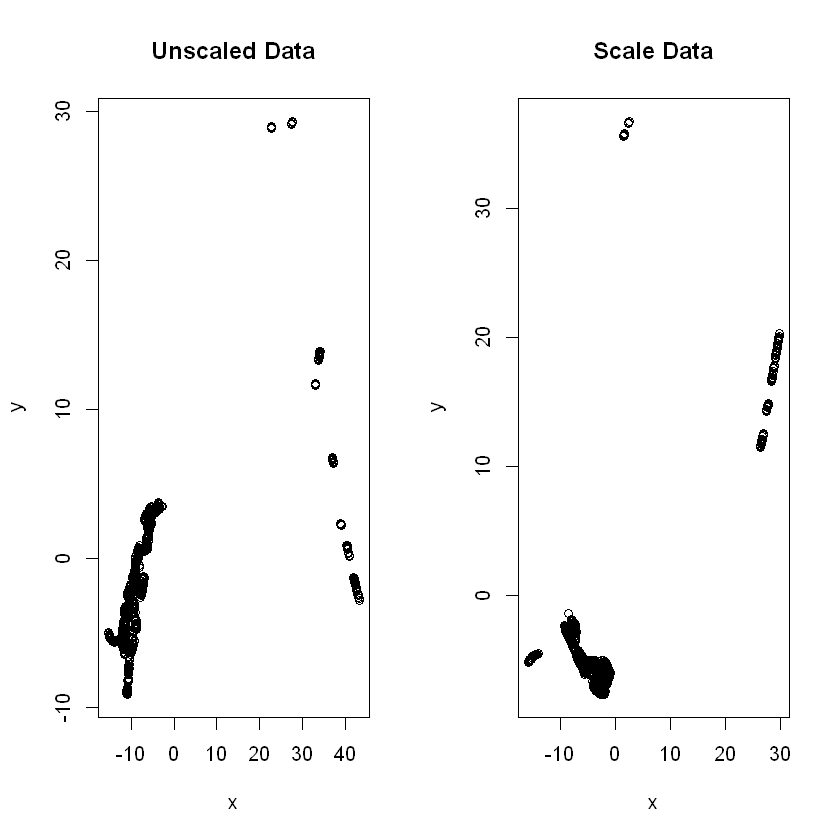

In [9]:
#options(repr.plot.width = 1, repr.plot.height = 0.75)
par(mfrow = c(1, 2))
plot(dados.umap$layout, xlab='x', ylab='y', main="Unscaled Data" )
plot(dados.umap_scale$layout, xlab='x', ylab='y', main="Scale Data" )
par(mfrow = c(1, 1))

In [10]:
dados2d <- cbind(dados[,1:2], as_tibble(dados.umap$layout), as_tibble(dados.umap_scale$layout))
colnames(dados2d) <- c('type', 'un', 'x_unscale', 'y_unscale', 'x_scale', 'y_scale')

Warning message:
"The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
i Using compatibility `.name_repair`."


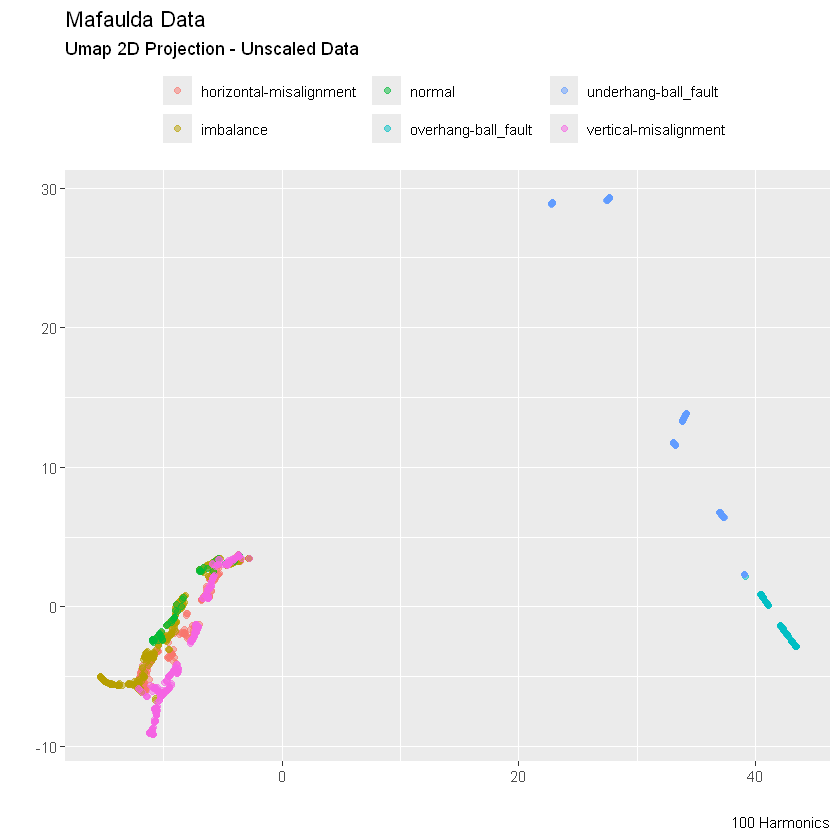

In [11]:
plt1 <- dados2d %>%
    ggplot(aes(x=x_unscale, y=y_unscale, color=type)) +
    geom_point(alpha=0.5) +
    theme(legend.position = 'top') +
    labs(title='Mafaulda Data', subtitle = 'Umap 2D Projection - Unscaled Data', caption = '100 Harmonics') +
    xlab('') +
    ylab('') + theme(legend.title=element_blank())
print(plt1)

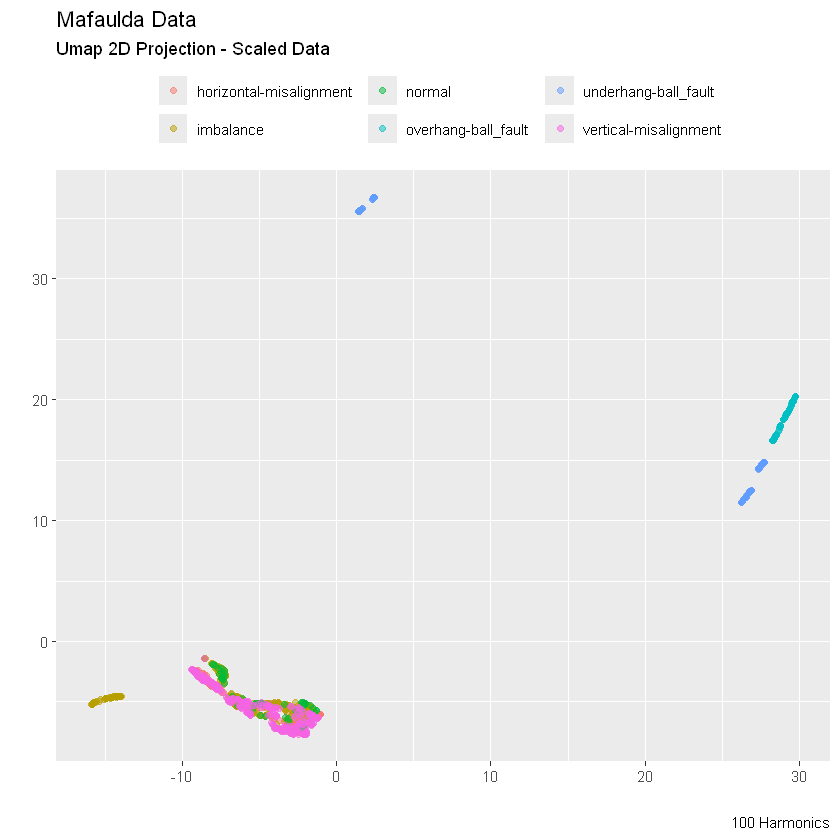

In [12]:
plt2 <- dados2d %>%
    ggplot(aes(x=x_scale, y=y_scale, color=type)) +
    geom_point(alpha=0.5) +
    theme(legend.position = 'top') +
    labs(title='Mafaulda Data', subtitle = 'Umap 2D Projection - Scaled Data', caption = '100 Harmonics') +
    xlab('') +
    ylab('') + theme(legend.title=element_blank())
print(plt2)

In [13]:
pdf("plots.pdf")
print(plt1)
print(plt2)
dev.off()

pdf 
  2

# HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) - ChatGPT

## Introdução

O **HDBSCAN** é uma extensão do algoritmo **DBSCAN** que realiza clustering baseado em densidade, mas com melhorias significativas para lidar com conjuntos de dados complexos. Ele foi introduzido por *Campello, Moulavi e Sander* em 2013.

O HDBSCAN é projetado para encontrar clusters de forma hierárquica, eliminando a necessidade de definir um único parâmetro de densidade (como o `eps` no DBSCAN), tornando-o mais adaptável a dados com densidades variadas.

---

## Fundamentos Matemáticos

O HDBSCAN combina conceitos de:

1. **Clustering por Densidade**: Agrupa pontos densamente conectados e identifica regiões esparsas como ruído.
2. **Hierarquia**: Gera uma hierarquia de clusters baseada em uma abordagem de árvore.
3. **Persistência de Clusters**: Seleciona automaticamente os clusters mais "estáveis" ao longo da hierarquia.

### Principais Etapas do Algoritmo

1. **Conversão do Espaço de Dados**:
   - Calcula a **distância mútua** entre os pontos usando uma métrica (geralmente Euclidiana).
   - Transforma as distâncias em **distâncias mútua corrigidas** através de uma função de densidade local.

2. **Construção de MST (Minimum Spanning Tree)**:
   - O HDBSCAN utiliza um **grafo de vizinhanças** e gera uma **árvore geradora mínima (MST)** para conectar os pontos baseando-se nas distâncias ajustadas.

3. **Hierarquia de Clusters**:
   - Gera uma **hierarquia de clusters** eliminando sucessivamente as arestas mais "longas" da MST, dividindo o grafo em componentes conectados.
   - Cada nível da hierarquia representa diferentes densidades.

4. **Extração de Clusters Planos**:
   - Analisa a persistência (estabilidade) dos clusters ao longo da hierarquia.
   - Seleciona automaticamente os clusters mais estáveis, que representam melhor os dados.

5. **Identificação de Ruído**:
   - Pontos que não pertencem a nenhum cluster são identificados como **outliers**.

---

## Principais Características

- **Adaptativo**: Não exige que os clusters tenham densidades uniformes.
- **Robustez**: Pode identificar clusters de formas arbitrárias e lidar com ruído de maneira eficiente.
- **Automatização**: Seleciona automaticamente os parâmetros de densidade mais apropriados.
- **Hierarquia**: Fornece uma representação hierárquica dos clusters.
- **Escalabilidade**: Melhor desempenho em comparação com algoritmos hierárquicos tradicionais.

### Parâmetros Importantes

- *min_samples*: Número mínimo de pontos para definir a densidade local.
- *min_cluster_size*: Tamanho mínimo para considerar um grupo de pontos como cluster.
- *metric*: Métrica de distância usada (ex.: Euclidiana, Manhattan, etc.).

---

## Comparação com DBSCAN

| Aspecto                  | HDBSCAN                      | DBSCAN                      |
|--------------------------|------------------------------|-----------------------------|
| **Densidade Variável**    | Suporta densidades variáveis | Requer densidade uniforme   |
| **Parâmetros**            | Mais flexível               | Necessita definir `eps`     |
| **Hierarquia**            | Gera hierarquia de clusters | Não gera hierarquia         |
| **Identificação de Ruído**| Robusta                     | Funciona, mas menos adaptável|
| **Complexidade**          | Levemente maior             | Menor                       |

---

## Aplicações

- **Análise de Dados Espaciais**: Clustering em dados geográficos ou espaciais.
- **Detecção de Outliers**: Identificação de pontos atípicos em grandes conjuntos de dados.
- **Bioinformática**: Agrupamento de dados genéticos ou de expressão gênica.
- **Marketing e Segmentação**: Agrupamento de clientes com características similares.
- **Processamento de Linguagem Natural**: Clustering de embeddings de texto.

In [14]:
cl <- hdbscan(dados2d[,5:6], minPts = 38 )
cl

HDBSCAN clustering for 1104 objects.
Parameters: minPts = 38
The clustering contains 6 cluster(s) and 18 noise points.

  0   1   2   3   4   5   6 
 18  45  70  39  52  70 810 

Available fields: cluster, minPts, coredist, cluster_scores,
                  membership_prob, outlier_scores, hc

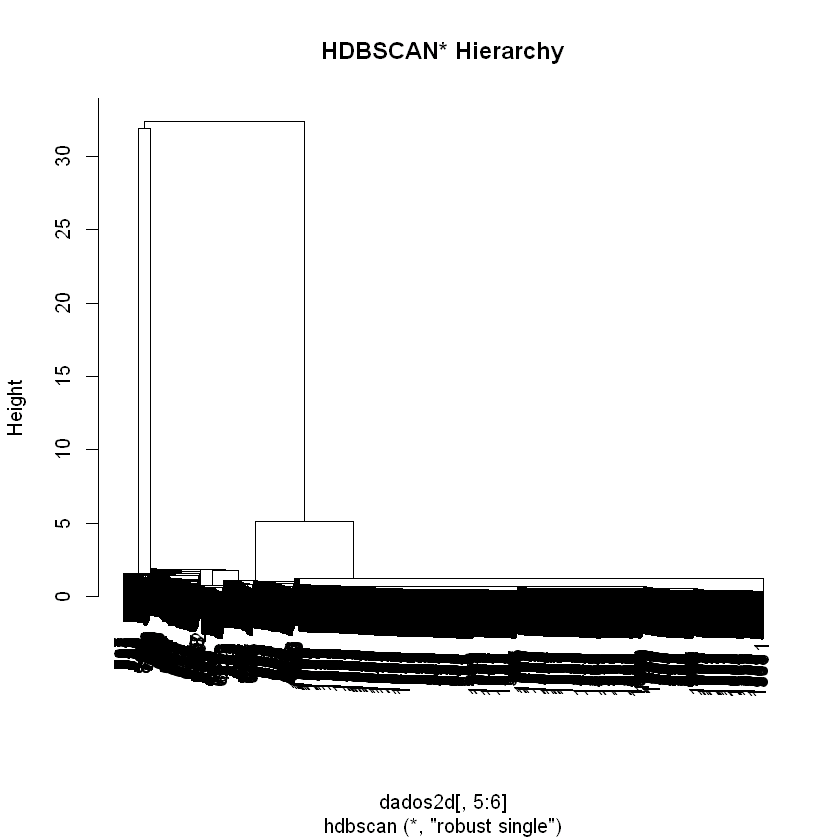

In [15]:
plot(cl$hc, main="HDBSCAN* Hierarchy")

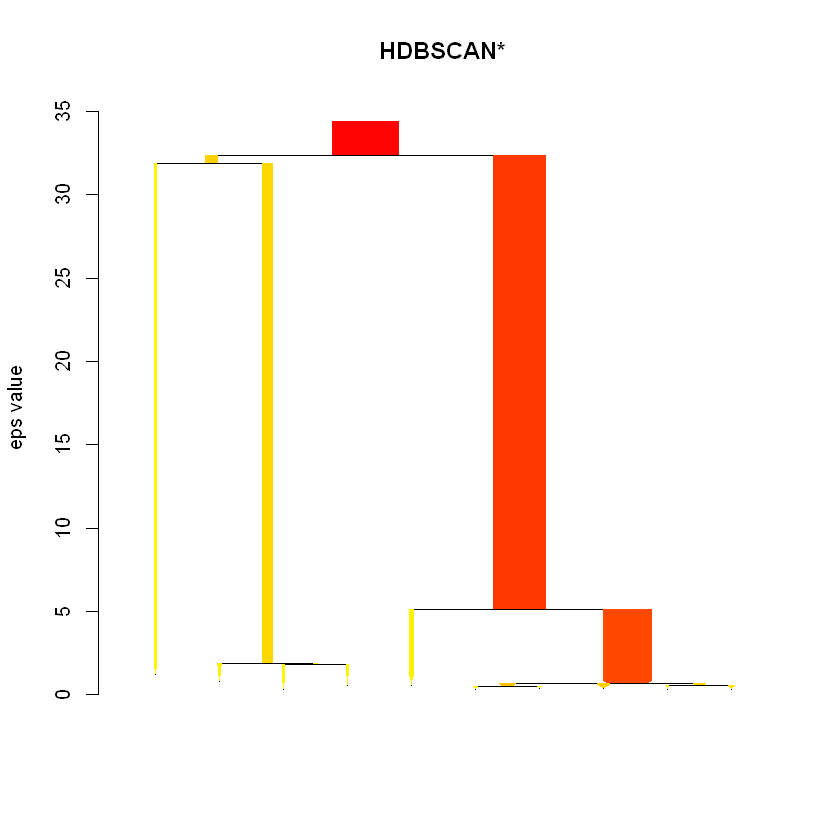

In [16]:
plot(cl)

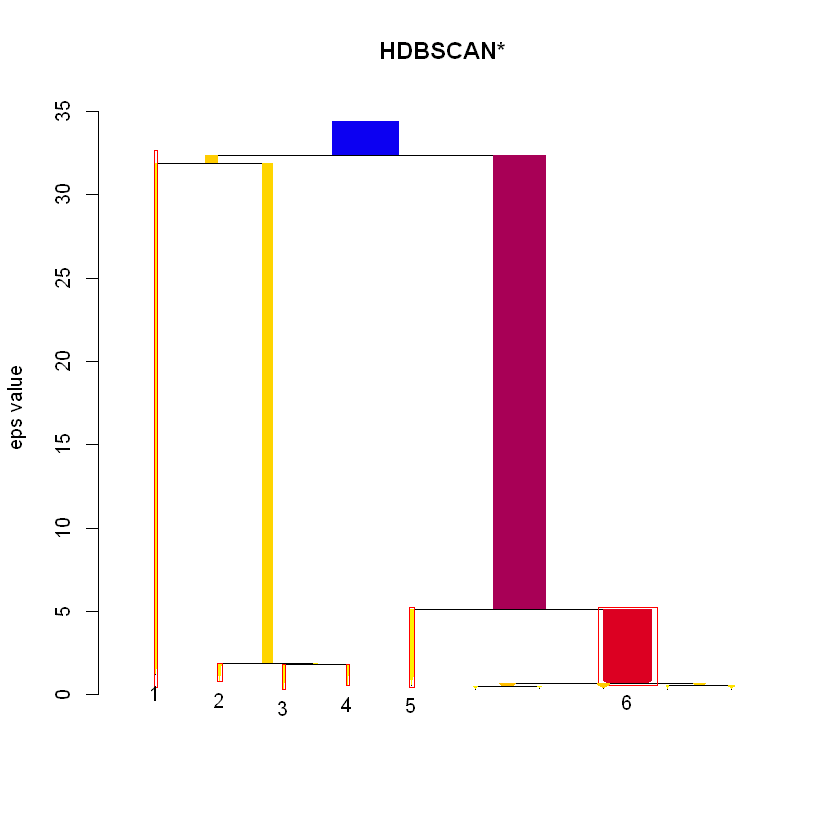

In [17]:
plot(cl, gradient = c("yellow", "orange", "red", "blue"), show_flat = TRUE)

In [18]:
print(cl$cluster_scores)

         1          2          3          4          5          6 
  29.76901   26.35681   56.87381   29.88269   74.20371 1026.35691 


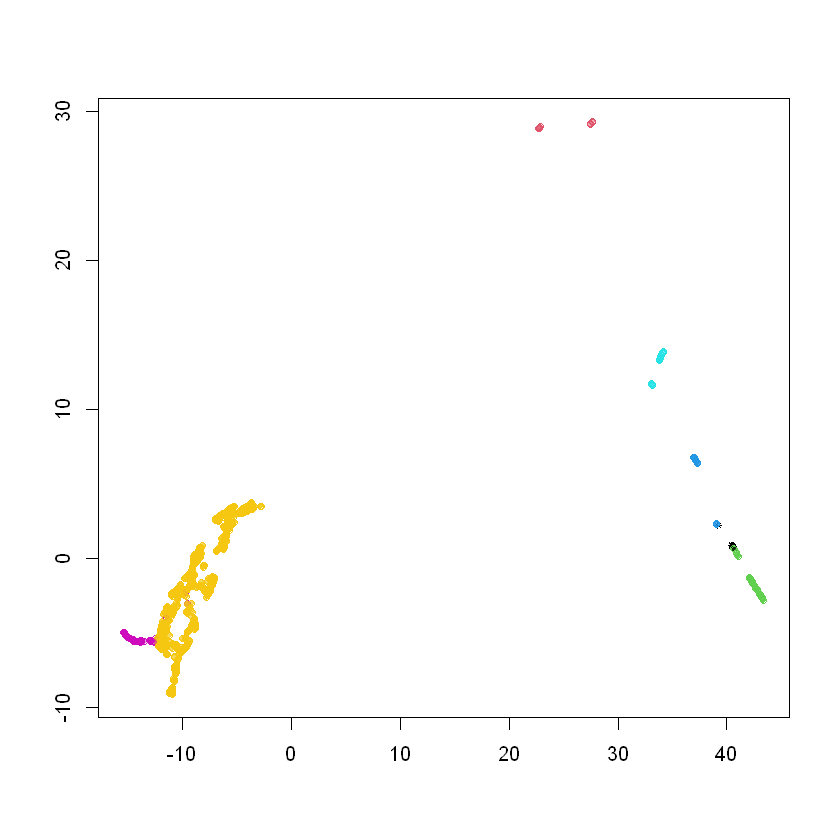

In [19]:
plot(dados2d[,3:4], col=cl$cluster+1, 
       pch=ifelse(cl$cluster == 0, 8, 1), # Mark noise as star
       cex=ifelse(cl$cluster == 0, 0.5, 0.75), # Decrease size of noise
       xlab=NA, ylab=NA)
colors <- sapply(1:length(cl$cluster), 
                   function(i) adjustcolor(palette()[(cl$cluster+1)[i]], alpha.f = cl$membership_prob[i]))
points(dados2d[,3:4], col=colors, pch=20)

In [20]:
table(dados2d %>% pull(type),cl$cluster)

                         
                            0   1   2   3   4   5   6
  horizontal-misalignment   0   0   0   0   0   0 197
  imbalance                 0   0   0   0   0  70 263
  normal                    0   0   0   0   0   0  49
  overhang-ball_fault      18   0  70   0   0   0   0
  underhang-ball_fault      0  45   0  39  52   0   0
  vertical-misalignment     0   0   0   0   0   0 301

In [21]:
table(paste(dados2d %>% pull(type), dados2d %>% pull(un)),cl$cluster)

                               
                                 0  1  2  3  4  5  6
  horizontal-misalignment 0.5mm  0  0  0  0  0  0 50
  horizontal-misalignment 1.0mm  0  0  0  0  0  0 49
  horizontal-misalignment 1.5mm  0  0  0  0  0  0 49
  horizontal-misalignment 2.0mm  0  0  0  0  0  0 49
  imbalance 10g                  0  0  0  0  0  0 48
  imbalance 15g                  0  0  0  0  0  0 48
  imbalance 20g                  0  0  0  0  0  2 47
  imbalance 25g                  0  0  0  0  0  1 46
  imbalance 30g                  0  0  0  0  0 34 13
  imbalance 35g                  0  0  0  0  0 33 12
  imbalance 6g                   0  0  0  0  0  0 49
  normal NA                      0  0  0  0  0  0 49
  overhang-ball_fault 20g        7  0 18  0  0  0  0
  overhang-ball_fault 35g        5  0 15  0  0  0  0
  overhang-ball_fault 6g         6  0 37  0  0  0  0
  underhang-ball_fault 20g       0 19  0 13 17  0  0
  underhang-ball_fault 35g       0  8  0 13 17  0  0
  underhang-ba

## Comparação com os dados sem redução da dimensionalidade

In [22]:
cl2 <- hdbscan(dados[,3:dim(dados)[2]], minPts = 38)
cl2

HDBSCAN clustering for 1104 objects.
Parameters: minPts = 38
The clustering contains 0 cluster(s) and 1104 noise points.

   0 
1104 

Available fields: cluster, minPts, coredist, cluster_scores,
                  membership_prob, outlier_scores, hc

In [23]:
table(dados %>% pull(type),cl2$cluster)

                         
                            0
  horizontal-misalignment 197
  imbalance               333
  normal                   49
  overhang-ball_fault      88
  underhang-ball_fault    136
  vertical-misalignment   301

In [24]:
table(paste(dados %>% pull(type), dados %>% pull(un)),cl2$cluster)

                               
                                 0
  horizontal-misalignment 0.5mm 50
  horizontal-misalignment 1.0mm 49
  horizontal-misalignment 1.5mm 49
  horizontal-misalignment 2.0mm 49
  imbalance 10g                 48
  imbalance 15g                 48
  imbalance 20g                 49
  imbalance 25g                 47
  imbalance 30g                 47
  imbalance 35g                 45
  imbalance 6g                  49
  normal NA                     49
  overhang-ball_fault 20g       25
  overhang-ball_fault 35g       20
  overhang-ball_fault 6g        43
  underhang-ball_fault 20g      49
  underhang-ball_fault 35g      38
  underhang-ball_fault 6g       49
  vertical-misalignment 0.51mm  51
  vertical-misalignment 0.63mm  50
  vertical-misalignment 1.27mm  50
  vertical-misalignment 1.40mm  50
  vertical-misalignment 1.78mm  50
  vertical-misalignment 1.90mm  50

# Algoritmo K-Means - ChatGPT

## Introdução  
O **K-Means** é um algoritmo de aprendizado não supervisionado usado para **agrupamento** (*clustering*). Ele particiona um conjunto de dados em **K clusters** distintos com base na proximidade dos pontos aos centróides, minimizando a variância intra-cluster.

---

## Funcionamento  

1. **Inicialização**:  
   - Escolha o número **K** de clusters desejados.  
   - Inicialize **K centróides** aleatoriamente ou por um método como *k-means++*.

2. **Iteração** (até convergência):  
   - **Passo 1: Atribuição**  
     Atribua cada ponto de dados \( x_i \) ao centróide mais próximo \( C_j \), onde a proximidade é calculada por uma **distância** (geralmente a distância Euclidiana):  
     \[
     d(x_i, C_j) = \| x_i - C_j \|_2^2
     \]
     Cada centróide representa o seu respectivo cluster.

   - **Passo 2: Atualização**  
     Recalcule os centróides como a **média aritmética** dos pontos atribuídos a cada cluster:  
     \[
     C_j = \frac{1}{|S_j|} \sum_{x \in S_j} x
     \]
     Onde \( S_j \) é o conjunto de pontos no cluster \( j \).

3. **Convergência**:  
   - O processo se repete até que os centróides não mudem significativamente ou uma condição de parada seja atingida (número máximo de iterações, por exemplo).  

---

## Fórmulas Matemáticas

O objetivo do algoritmo K-Means é **minimizar a soma dos erros quadráticos dentro dos clusters** (**Within-Cluster Sum of Squares**, WCSS):

\[
\text{WCSS} = \sum_{j=1}^K \sum_{x_i \in S_j} \| x_i - C_j \|^2
\]

Onde:  
- \( K \): número de clusters;  
- \( S_j \): conjunto de pontos atribuídos ao cluster \( j \);  
- \( C_j \): centróide do cluster \( j \).

---

## Vantagens  
- Simples e eficiente para conjuntos de dados grandes.  
- Convergência rápida em prática.  
- Fácil de interpretar e implementar.  

---

## Desvantagens  
- Sensível à inicialização dos centróides.  
- Assume que os clusters são esféricos e de tamanho semelhante.  
- Pode convergir para mínimos locais do WCSS.  
- O valor de \( K \) deve ser escolhido a priori.

---

## Aplicações  
- Compressão de imagens.  
- Segmentação de clientes (*Customer Segmentation*).  
- Agrupamento de documentos e textos.  
- Análise de padrões em grandes conjuntos de dados.

---

## Pseudocódigo  

```text
Entrada: Conjunto de dados X = {x_1, x_2, ..., x_n}, número de clusters K.
Saída: K clusters {C_1, C_2, ..., C_K}.

1. Inicialize K centróides aleatoriamente: C_1, C_2, ..., C_K.
2. Enquanto não convergir (ou atingir limite de iterações):
      a. Para cada ponto x_i em X:
            - Atribua x_i ao cluster com o centróide mais próximo.
      b. Para cada cluster C_j:
            - Recalcule o centróide como a média dos pontos atribuídos ao cluster.
3. Retorne os clusters e centróides finais.


In [25]:
k <- kmeans(dados2d[,5:6], 6 )

In [27]:
table(dados2d %>% pull(type), k$cluster)

                         
                            1   2   3   4   5   6
  horizontal-misalignment   0   0   0  53  60  84
  imbalance                70   0   0  76  77 110
  normal                    0   0   0  15  13  21
  overhang-ball_fault       0   0  88   0   0   0
  underhang-ball_fault      0  45  91   0   0   0
  vertical-misalignment     0   0   0  88  75 138

In [28]:
table(paste(dados %>% pull(type), dados %>% pull(un)),  k$cluster)

                               
                                 1  2  3  4  5  6
  horizontal-misalignment 0.5mm  0  0  0 12 16 22
  horizontal-misalignment 1.0mm  0  0  0 14 17 18
  horizontal-misalignment 1.5mm  0  0  0 11 15 23
  horizontal-misalignment 2.0mm  0  0  0 16 12 21
  imbalance 10g                  0  0  0 13 13 22
  imbalance 15g                  0  0  0 12 12 24
  imbalance 20g                  2  0  0 10 16 21
  imbalance 25g                  1  0  0 12 18 16
  imbalance 30g                 34  0  0 11  0  2
  imbalance 35g                 33  0  0  7  3  2
  imbalance 6g                   0  0  0 11 15 23
  normal NA                      0  0  0 15 13 21
  overhang-ball_fault 20g        0  0 25  0  0  0
  overhang-ball_fault 35g        0  0 20  0  0  0
  overhang-ball_fault 6g         0  0 43  0  0  0
  underhang-ball_fault 20g       0 19 30  0  0  0
  underhang-ball_fault 35g       0  8 30  0  0  0
  underhang-ball_fault 6g        0 18 31  0  0  0
  vertical-misalig

## Conclusão  

Os resultados obtidos evidenciam que a **redução de dimensionalidade** pode melhorar de forma significativa o desempenho de algoritmos de aglomeração. No presente estudo, verificou-se que a aplicação do algoritmo **HDBSCAN** nos **dados brutos** resultou na classificação de todos os pontos como *outliers*. Além disso, em relação à normalização dos dados, constatou-se que a normalização pelo **desvio padrão** resultou em uma perda de qualidade no desempenho do HDBSCAN. Por outro lado, a **normalização em relação à média** apresentou uma melhora nos resultados, o que indica uma maior adequação dessa abordagem para os dados analisados.  

Um dos principais desafios identificados é a **definição do número ideal de dimensões** para a execução eficiente do algoritmo. Nesse sentido, métodos baseados em **autoencoders de redes neurais** se destacam por possuírem processos de **otimização de metaparâmetros** integrados, o que oferece uma vantagem em relação a técnicas como **UMAP** ou **t-SNE**, que não incluem essa otimização de forma nativa.  

No que diz respeito aos dados analisados, observou-se uma **clara distinção** entre as classes **overhang-ball_fault** e **underhang-ball_fault** em comparação às demais classes. Contudo, no caso do **funcionamento normal do motor**, não foi identificada uma separação significativa em relação às demais condições. Isso revela uma dificuldade substancial em distinguir o **funcionamento normal** do motor de situações de **desbalanceamento** ou **desalinhamento**. Tal desafio representa um obstáculo importante para as equipes de engenharia no desenvolvimento de um **detector de falhas** eficaz para essa classe específica de mau funcionamento.

Com relação aos algoritmos HDBSCAN e K-means, ambos desempenharam resultados semelhantes, porém o HDBSCAN conseguiu agrupar os pontos da classe normal em um único grupo e distinguir melhor os grupos overhang-ball_fault e underhang-ball.
